<a href="https://colab.research.google.com/github/yuanchaohu/Colab_learning/blob/main/PyTorch_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch playground

In [ ]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



In [ ]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 64)
    self.fc2 = nn.Linear(64,32)
    self.fca = nn.Linear(32, 16)
    self.fc3 = nn.Linear(16,10)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fca(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    
    return x

model = FMNIST()

In [ ]:
model.to(device)

FMNIST(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fca): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)

- The only change we have made to the code is that we are going to track the training loss, the testing loss and the accuracy across the 30 epochs.
- We'll print out the train loss, the test loss and the accuracy after each epoch.
- Because we are running this over 30 epochs this will take a bit longer to run - approx 15 minutes.

In [ ]:
from torch import optim
criterion = nn.NLLLoss() #negative log likelihood loss function
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 10
train_tracker, test_tracker, accuracy_tracker = [], [], []


for i in range(num_epochs):
    cum_loss = 0
    
    for batch, (images, labels) in enumerate(trainloader,1):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() #initialize the gradient before training instead of relying on previous training results
        output = model(images) #get predicted value by training
        loss = criterion(output, labels) #get loss value by comparing to labels
        loss.backward() #backpropagation to optimize the weights
        optimizer.step()
        
        cum_loss += loss.item()
    
    train_tracker.append(cum_loss/len(trainloader))
    print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss/len(trainloader)} | ",end='')
    
    test_loss = 0
    num_correct = 0
    total = 0
    
    for batch, (images, labels) in enumerate(testloader,1):
        images = images.to(device)
        labels = labels.to(device)
        
        logps = model(images)
        batch_loss = criterion(logps, labels)        
        test_loss += batch_loss.item()
        
        output = torch.exp(logps)
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
    
    test_tracker.append(test_loss/len(testloader))
    print(f"Test loss: {test_loss/len(testloader)} | ", end='')
    accuracy_tracker.append(num_correct/total)
    print(f'Accuracy : {num_correct/total}')        
print(f'\nNumber correct : {num_correct}, Total : {total}')
print(f'Accuracy of the model after {num_epochs} epochs on the 10000 test images: {num_correct * 100 / total}% ')
    
    

Epoch(1/10) | Training loss: 1.4976821784525791 | Test loss: 0.8749118261276536 | Accuracy : 0.6788
Epoch(2/10) | Training loss: 0.705141977810148 | Test loss: 0.6541695226529601 | Accuracy : 0.7578
Epoch(3/10) | Training loss: 0.5674055519897038 | Test loss: 0.547735067499671 | Accuracy : 0.8018
Epoch(4/10) | Training loss: 0.5053300910285795 | Test loss: 0.5161921894474394 | Accuracy : 0.8153
Epoch(5/10) | Training loss: 0.47219342296756406 | Test loss: 0.4986985211919068 | Accuracy : 0.8218
Epoch(6/10) | Training loss: 0.44972787894356225 | Test loss: 0.47217898403003716 | Accuracy : 0.8301
Epoch(7/10) | Training loss: 0.4320468177864038 | Test loss: 0.46612542573433774 | Accuracy : 0.8349
Epoch(8/10) | Training loss: 0.41603835821469454 | Test loss: 0.4418200627443897 | Accuracy : 0.8414
Epoch(9/10) | Training loss: 0.40163409427157853 | Test loss: 0.43948661844441844 | Accuracy : 0.841
Epoch(10/10) | Training loss: 0.38958700836848603 | Test loss: 0.41889274243716224 | Accuracy : 

- Has the accuracy of the model increased?
- Now plot the training loss vs the test loss over 30 epochs.

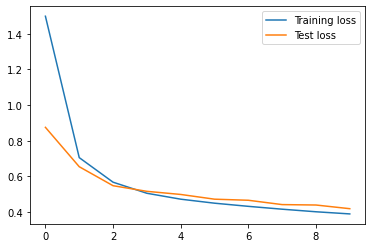

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(test_tracker, label='Test loss')
plt.legend()

- Now add the accuracy to the mix.

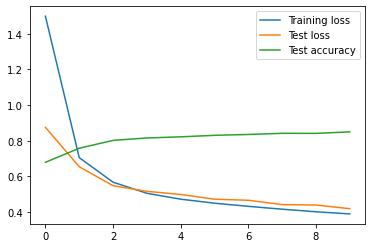

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(test_tracker, label='Test loss')
plt.plot(accuracy_tracker, label='Test accuracy')
plt.legend()

## Further challenges and experiments
- Can you get better accuracy from a model if you :
    - Add more layers? [YES]
    - Change the number of nodes in the layers? [decrease the nodes will deteriorate the performance]
    - Train over fewer/higher epochs? [tried with 10 epochs]
    
- Can you improve on your results if you add additional layers like [Dropout](https://pytorch.org/docs/master/nn.html#torch.nn.Dropout)